# Train on separate images (CNN-Only) on InceptionV3 output

In [1]:
import numpy as np
import os
from os.path import join
from keras import layers, callbacks, metrics
from keras.models import Model
from utils import preprocess_images_tf, take
from tqdm import tqdm
from image_generators import count_num_videos
from inception_generators import train_generator_single_images, valid_generator_single_images

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras_utils import set_keras_session
set_keras_session(0.45)

In [3]:
dataset = 'UCF11'
nb_classes = int(dataset[3:])

In [4]:
frame_number = 50
width = 320
height = 240

dataset_dir = join('datasets', dataset, ('separate_frames_{}_h_{}_w_{}_inception').format(frame_number, height, width))

train_samples_count, valid_samples_count = count_num_videos(dataset_dir, 'train', 'valid')

In [5]:
from functools import partial

top_3_k_categorical_accuracy = partial(metrics.top_k_categorical_accuracy, k=3)
top_3_k_categorical_accuracy.__name__ = 'top_3'

In [6]:
from keras.models import Model

input_layer = layers.Input((2048,))
x = input_layer
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(nb_classes, activation='softmax')(x)

# this is the model we will train
model = Model(input_layer, outputs=predictions)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 11)                5643      
Total params: 1,054,731
Trainable params: 1,054,731
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
from keras.optimizers import SGD

model.compile(optimizer=SGD(momentum=0.9, nesterov=True), loss='categorical_crossentropy', 
              metrics=['accuracy', top_3_k_categorical_accuracy])

model_filepath = join('models', dataset, 'inception_dense512_dropout05_trained_10_epochs_no_fine_tuning.h5')
checkpointer = callbacks.ModelCheckpoint(filepath=model_filepath, monitor='val_acc', verbose=1, save_best_only=True)
early_stopper = callbacks.EarlyStopping(monitor='val_acc', patience=3)

In [8]:
batch_size = 128
train_generator = train_generator_single_images(dataset_dir, batch_size)
valid_generator = valid_generator_single_images(dataset_dir)

In [9]:
def train_model(**kwargs):
    
    return model.fit_generator(train_generator,
                    steps_per_epoch=train_samples_count * frame_number // batch_size, 
                    validation_data=valid_generator,
                    validation_steps=valid_samples_count,
                    **kwargs)

In [10]:
history = train_model(epochs=20, callbacks=[checkpointer, early_stopper])

Epoch 1/20
439/439 [==============================] - 29s 65ms/step - loss: 0.2782 - acc: 0.9156 - top_3: 0.9782 - val_loss: 0.5446 - val_acc: 0.8286 - val_top_3: 0.9611

Epoch 00001: val_acc improved from -inf to 0.82857, saving model to models/UCF11/inception_dense512_dropout05_trained_10_epochs_no_fine_tuning.h5
Epoch 2/20
439/439 [==============================] - 29s 66ms/step - loss: 0.0774 - acc: 0.9780 - top_3: 0.9982 - val_loss: 0.6131 - val_acc: 0.8284 - val_top_3: 0.9538

Epoch 00002: val_acc did not improve
Epoch 3/20
439/439 [==============================] - 29s 66ms/step - loss: 0.0488 - acc: 0.9872 - top_3: 0.9990 - val_loss: 0.6189 - val_acc: 0.8351 - val_top_3: 0.9587

Epoch 00003: val_acc improved from 0.82857 to 0.83505, saving model to models/UCF11/inception_dense512_dropout05_trained_10_epochs_no_fine_tuning.h5
Epoch 4/20
439/439 [==============================] - 29s 67ms/step - loss: 0.0352 - acc: 0.9909 - top_3: 0.9995 - val_loss: 0.6299 - val_acc: 0.8302 - val

Here we collect metrics about the accuracy on the video, since the model only works with single images:
* Approach 1: Compute the mean of all predictions on all frames of a video, then take the best prediction.
* Approach 2: Take the predicted best for each frame (argmax), and count how many times that class is predicted as the best one into the video frames. Then take the class with the highest count.
* Approach 3 (not implemented but tested): instead of the mean, compute the product (since we work with probabilities). Yields a lower result than using the mean.

Here we load the best model:

In [13]:
from keras.models import load_model

model = load_model(model_filepath, custom_objects={'top_3': top_3_k_categorical_accuracy})

In [14]:
def collect_statistics_on_videos():

    from collections import Counter

    count_videos = 0
    count_top_1 = 0
    count_top_3 = 0
    count_top_1_argmax = 0

    for frames, labels in tqdm(take(valid_generator, valid_samples_count), total=valid_samples_count):

        ### Compute the predicted labels using the model

        true_labels = labels[0]
        true_label_idx = np.argmax(true_labels)
        predicted_labels = model.predict(frames)

        ### Update counters with Approach 1 (mean)

        predicted_labels_mean = np.mean(predicted_labels, axis=0)
        predicted_labels_mean_idx = np.argmax(predicted_labels_mean)
        idx_sorted_top_3 = np.argsort(predicted_labels_mean)[-3:]

        if true_label_idx in idx_sorted_top_3:
            count_top_3 += 1

        if true_label_idx == predicted_labels_mean_idx:
            count_top_1 += 1

        ### Update count with Approach 2 (highest count)

        predicted_labels_argmax = np.argmax(predicted_labels, axis=1)
        counter = Counter(predicted_labels_argmax)

        if counter.most_common(1)[0][0] == true_label_idx:
            count_top_1_argmax += 1

        ### Update number of videos

        count_videos += 1
        
        
    print('Top 1 accuracy (using mean):', count_top_1 / count_videos)
    print('Top 3 accuracy (using mean):', count_top_3 / count_videos)
    print('Top 1 accuracy (using highest count):', count_top_1_argmax / count_videos)

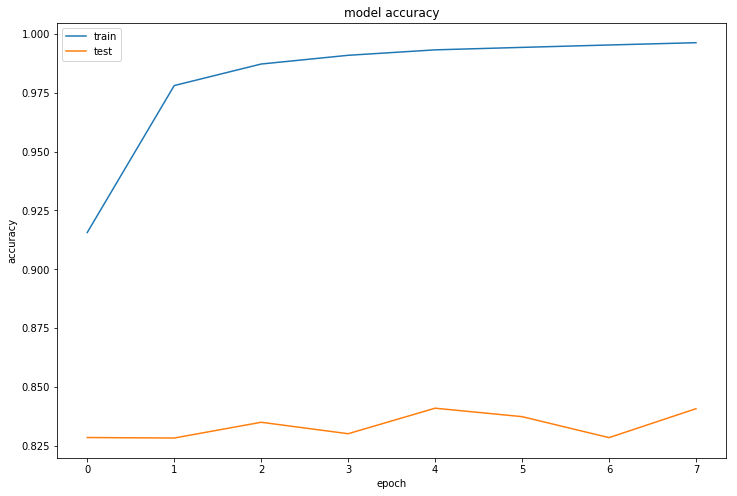

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
collect_statistics_on_videos()

100%|██████████| 469/469 [00:01<00:00, 402.95it/s]

Top 1 accuracy (using mean): 0.8891257995735607
Top 3 accuracy (using mean): 0.9872068230277186
Top 1 accuracy (using highest count): 0.8891257995735607
